In [199]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [200]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'

#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [201]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    var_names = data_trunc.filter(regex=all_vars).columns
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}, var_names

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    return {'X':X, 'y':y}
    

In [260]:
feature_cols = ['CT', 'L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS11_bl', 'ADAS13_bl', 'MMSE_bl']

cv_data, var_names = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
test_data = load_test_data(test_file, clinical_scale, feature_cols)
print cv_data['X_train'][0].shape
print cv_data['y_train'][0].shape

(522, 76)
(522, 3)


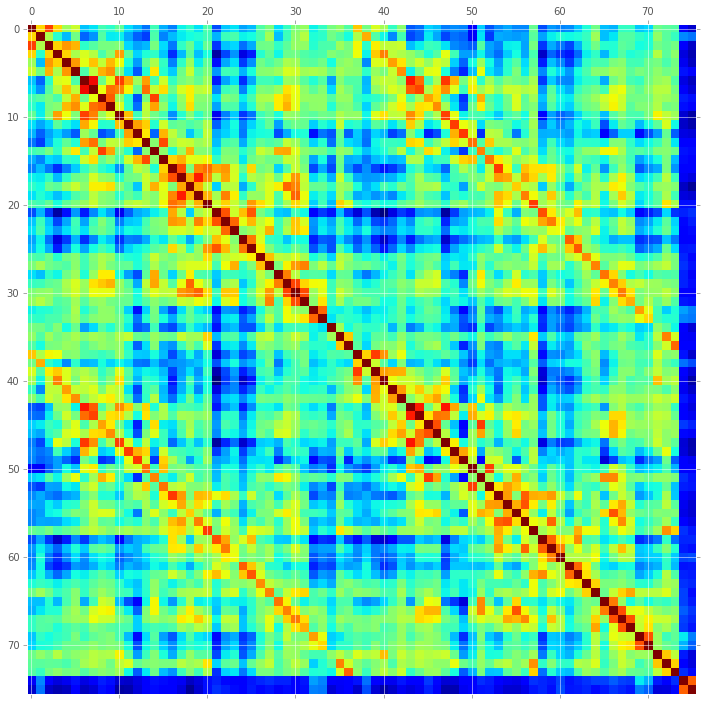

In [261]:
# Correlation matrix
data = pd.read_pickle(train_val_file)
all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
data_trunc = data.filter(regex=all_vars)
data_trunc = data_trunc.dropna(how='any')

plt.matshow(data_trunc.corr())




In [262]:
# Define a model

# The two independent vars are highly correlated, so an ordinary least squares regression may
# be the best idea: the model will be highly sensitive to random errors in the response var. See 
# https://en.wikipedia.org/wiki/Multicollinearity

# Space for hyperparam search
alphas=np.logspace(-5,5,num=100)

# We can instead try a ridge regression:
from sklearn import linear_model
from sklearn.metrics import r2_score
BaseReg=linear_model.RidgeCV
    
class Regression(BaseReg):
    def __init__(self, *args, **kwargs):
        super(Regression, self).__init__(*args,**kwargs)
    

    def fit(self, X, y):
        self = super(Regression, self).fit(X,y)
        df = X.shape[0] - X.shape[1] - 1
        y_hat = self.predict(X)
        sse = np.sum(np.square(y - y_hat), axis=0)
        self.variance_y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I
        self.zscores_ = self.coef_ / np.sqrt(self.variance_y * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, y):
        N, P = X.shape
        y_hat = self.predict(X)
        
        # R2 and adjusted R2:
        self.R2 = r2_score(y, y_hat)
        self.rmse = np.sqrt(mean_squared_error(y, y_hat))
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_y = np.var(y)
        
        self.ssm = np.sum(np.square(y_hat - y.mean()))
        self.sse = np.sum(np.square(y - y_hat))
        self.sst = np.sum(np.square(y - y.mean()))
        self.r = scipy.stats.pearsonr(y, y_hat)
        
        return self.R2
        

if BaseReg==linear_model.RidgeCV:
    reg = Regression(alphas=alphas, normalize=False, fit_intercept=True)
else:
    reg = Regression(normalize=False, fit_intercept=True)

In [263]:
X = cv_data['X_valid'][0]
N, P = X.shape
print N, P


59 76


In [285]:
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

# Cross-validation loop
stats = np.zeros(shape=(3,10,5))
coefs = np.zeros(shape=(3,10,X.shape[1]))
reg_params = np.zeros(shape=(3,10,2))
zscores = []
pvals = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold]
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold]
    
    # Normalize features independently:
    scaler = sklearn.preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    X_v = scaler.transform(X_v)
    
    for i, scale in enumerate(clinical_scale):
        reg.fit(X, y[:, i])
        y_hat = reg.predict(X)
        # validation:
        y_hat_v = reg.predict(X_v)
        mse = mean_squared_error(y_v[:, i], y_hat_v)
        reg.score(X_v, y_v[:,i])
        
        # Book keepin':
        stats[i, fold, : ] = np.array([reg.R2, reg.adj_R2, reg.rmse, reg.r[0], reg.r[1]])
        reg_params[i, fold, :] = np.array([reg.alpha_])
        coefs[i, fold, :] = reg.coef_
    

In [286]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [287]:
from IPython.display import display
mean_coefs = np.mean(coefs, axis=1).T
best_alpha=scipy.stats.mode(alphas)[0][0]

print 'Mode of MT Lasso regularization param: {}'.format(best_alpha)

for i in range(y.shape[1]):
    print '{} scale regression:'.format(clinical_scale[i])
    model=make_table(10, ['Model'], R2=stats[i,:,0], Adj_R2=stats[i,:,1], RMSE=stats[i,:,2], r=stats[i,:,3], pval=stats[i,:,4])
    display(model)




Mode of MT Lasso regularization param: 1e-05
ADAS11_bl scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.652234,0.185098,0.000718,0.001051,0.487537,0.077936,0.209001,0.060755,5.284567,0.528284


ADAS13_bl scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.563219,0.182462,0.000208,0.000373,0.524997,0.066777,0.251904,0.058574,7.589829,0.69839


MMSE_bl scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.717356,0.248057,0.018118,0.049649,0.448192,0.117342,0.17713,0.107164,2.302204,0.148684


76 Features with non-zero coefficients:


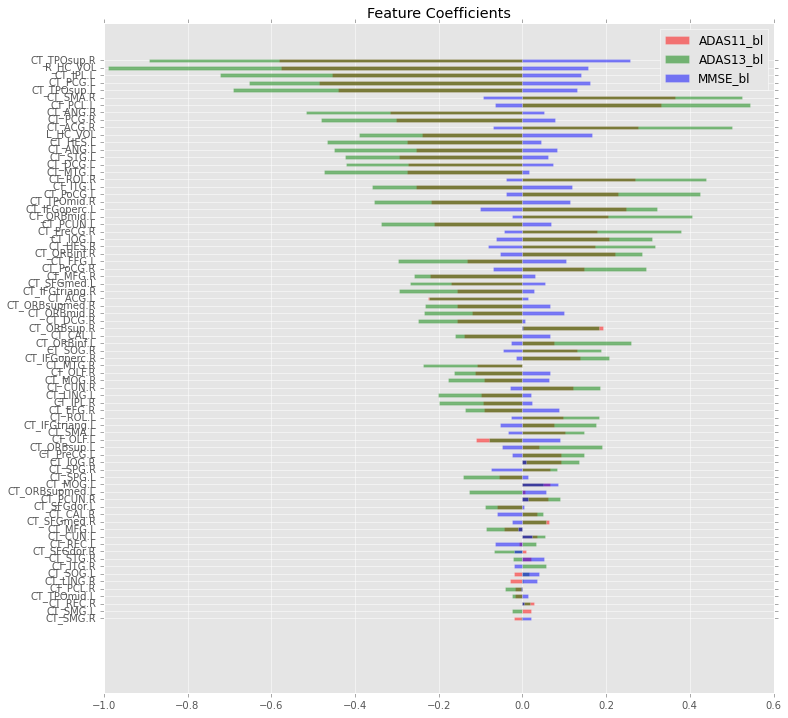

In [288]:
feats = zip(var_names, mean_coefs)
feats.sort(reverse=False, key=lambda x: np.sum(abs(x[1])))
feats = [feat for feat in feats if np.sum(abs(feat[1])) > 0.0]
coef_matrix = np.array(zip(*feats)[1])

# Plot the feature importances of the classifier
print '{} Features with non-zero coefficients:'.format(len(feats))
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))

#print [coef for coef in zip(*feats)[1]]

plt.barh(y_pos, width=coef_matrix[:,0], height=0.5, color='r', align="center", alpha=0.5, label='{}'.format(clinical_scale[0]))
plt.barh(y_pos, width=coef_matrix[:,1], height=0.5, color='g', align="center", alpha=0.5, label='{}'.format(clinical_scale[1]))
plt.barh(y_pos, width=coef_matrix[:,2], height=0.5, color='b', align="center", alpha=0.5, label='{}'.format(clinical_scale[2]))
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [289]:
from sklearn.linear_model import Ridge

# Fit final model for testing
X_tv = np.concatenate([cv_data['X_train'][0], cv_data['X_valid'][0]], axis=0)
y_tv = np.concatenate([cv_data['y_train'][0], cv_data['y_valid'][0]], axis=0)
print X.shape
print y.shape

# Normalize
scaler = sklearn.preprocessing.StandardScaler().fit(X_tv)
X_tv = scaler.transform(X_tv)

X_t = test_data['X']
y_t = test_data['y']

# Normalize:
X_t = scaler.transform(X_t)


(523, 76)
(523, 3)


In [290]:

test_stats = np.zeros(shape=(y_t.shape[1], 4))
y_hats = np.zeros(shape=(X_t.shape[0], y_t.shape[1]))

for i, scale in enumerate(clinical_scale):
    if BaseReg==linear_model.RidgeCV:
        test_reg = Ridge(alpha=alpha, normalize=False, fit_intercept=True)
    else:
        test_reg = Regression(normalize=False, fit_intercept=True)
        
    test_reg.fit(X_tv, y_tv[:,i])
    y_hat_t=test_reg.predict(X_t)
    y_hats[:,i] = y_hat_t
    R2 = r2_score(y_t[:,i], y_hat_t)
    r = scipy.stats.pearsonr(y_t[:,i], y_hat_t)
    rmse = np.sqrt(mean_squared_error(y_t[:,i], y_hat_t))
    test_stats[i,:] = np.array([rmse, R2, r[0], r[1]])

,Scale,RMSE,R2,correlation,p-val
0,ADAS11_bl,5.834417,0.191848,0.440349,1.479497e-06
1,ADAS13_bl,8.028548,0.238232,0.490061,5.511503e-08
2,MMSE_bl,2.297213,0.105449,0.370008,6.935239e-05


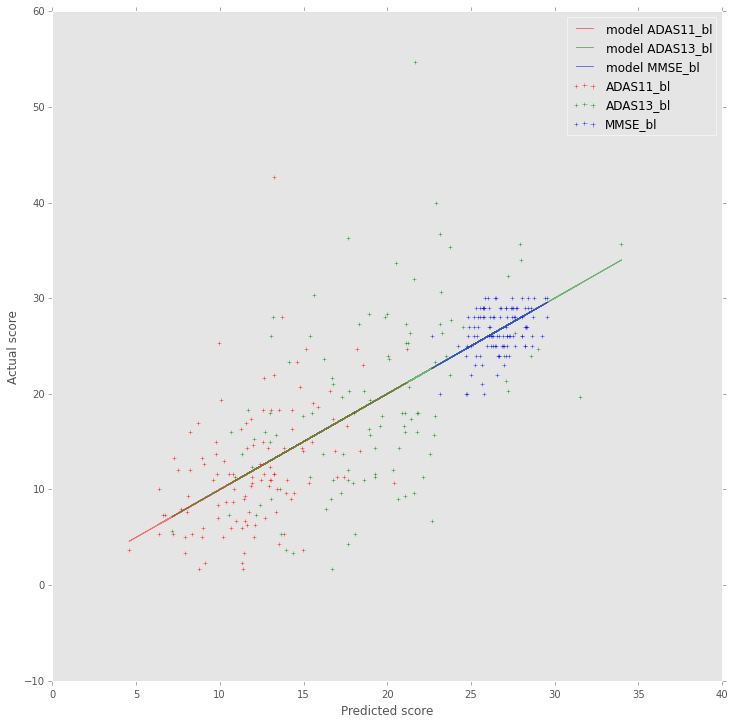

In [291]:
line_col = {0: 'red', 1: 'green', 2: 'blue'}

table = pd.DataFrame(test_stats)
table.insert(0, 'Scale', clinical_scale)
table.columns = ['Scale', 'RMSE', 'R2', 'correlation', 'p-val']
display(table)
for i, scale in enumerate(clinical_scale):
    ax=plt.subplot(1,1,1)
    plt.scatter(y_hats[:,i], y_t[:,i], marker='+', color=line_col[i], alpha=.75, label='{}'.format(scale))
    plt.plot(y_hats[:,i], y_hats[:,i], color=line_col[i], linewidth=1, alpha=0.5, label='model {}'.format(scale))
plt.legend()
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
plt.grid()    
plt.show()